In [1]:
!pip install pandas rapidfuzz networkx matplotlib

Defaulting to user installation because normal site-packages is not writeable
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.0/12.0 MB 30.0 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 6.0 MB/s eta 0:00:00eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 2.8 MB/s eta 0:00:00eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 17.2 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 12.5 MB/s eta 0:00:00ta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 4.3 MB/s eta 0:00:00eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.6/16.6 MB 9.7 MB/s eta 0:00:000:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.6/4.6 MB 13.3 MB/s eta 0:00:00ta 0:00:01


In [2]:
import pandas as pd
import numpy as np
from rapidfuzz import fuzz, process
import networkx as nx
from collections import Counter
import matplotlib.pyplot as plt

## Cluster book titles

In [3]:
real_books = pd.read_csv('../results/all_extracted_titles_real_books_extra_250624.csv', index_col=0)
real_books.head()

,original_title,translated_title,author,article_id,date,text
2,Alphabetisk Postadressebog,Alphabetical Postal Address Book,Anthon,aar_182421,1830-01-08,"Alphabetisk Postadressebog, indeholdende Navne..."
4,Alphabetisk Postadressebog,Alphabetical Postal Address Book,Anthon,aar_182527,1830-01-14,"Alphabetisk Postadressebog, indeholdende Navne..."
9,Greven af Burgund,The Count of Burgundy,Kotzebue,aar_183034,1830-02-09,Bekjendtgjørelser. Til Benefice for Jfr. Schla...
10,Rosakkernes Leir,The Camp of the Rosacans,NO_AUTHOR,aar_183034,1830-02-09,Bekjendtgjørelser. Til Benefice for Jfr. Schla...
11,"Dæmona, eller: Bjergpigen","Dæmona, or The Mountain Girl",NO_AUTHOR,aar_183242,1830-02-19,Bekjendtgjørelser. Fastelavnsmandag Aften opfø...


In [4]:
# Step 1: Frequency count from real data
freq_counter = Counter(real_books['original_title'])

# Step 2: Build similarity graph
unique_titles = real_books['original_title'].unique()
G = nx.Graph()
G.add_nodes_from(unique_titles)

threshold = 85
for i, t1 in enumerate(unique_titles):
    for j, t2 in enumerate(unique_titles):
        if i < j and fuzz.ratio(t1, t2) >= threshold:
            G.add_edge(t1, t2)

# Step 3: Assign each title to the most frequent variant in its cluster
title_to_label = {}
for cluster in nx.connected_components(G):
    cluster_titles = list(cluster)
    most_frequent = max(cluster_titles, key=lambda t: freq_counter[t])
    for t in cluster_titles:
        title_to_label[t] = most_frequent

# Step 4: Map cluster label and compute similarity
real_books['cluster_label'] = real_books['original_title'].map(title_to_label)
real_books['similarity_to_label'] = real_books.apply(
    lambda row: fuzz.ratio(row['original_title'], row['cluster_label']),
    axis=1
)

# ✅ Final DataFrame
df_clustered = real_books[['article_id', 'author', 'original_title', 'cluster_label', 'similarity_to_label']]

In [5]:
df_clustered.shape

(1999, 5)

In [6]:
df_clustered['cluster_label'].nunique()

1312

In [7]:
df_clustered.to_csv('../results/title_clusters_extra_250624.csv')

## Round 2 with cleaned dataset

In [9]:
df = pd.read_csv('../results/titles_clean_250619.csv', index_col=0)
df = df[['article_id', 'author', 'last_name', 'clean_title']]
df.head()

,article_id,author,last_name,clean_title
5307,thi_018759,Aaben,Aaben,Practisk Regnebog for Begyndere
9723,ode_156813,T. Aabye,Aabye,Veiledning for Bonden til selv at opmaale og a...
4870,ode_165427,T. Aabye,Aabye,Veiledning for Bonden til selv at opmaale og a...
4001,ode_084648,J. F. Abel,Abel,Udførlig Fremstilling af Grunden for vor Tro p...
1095,lol_059597,L. Abrahams,Abrahams,Franske Stilleøvelser


In [10]:
df_extra = pd.read_csv('../results/title_clusters_aarhus_extra.csv', index_col=0)
df_extra = df_extra[['article_id', 'author', 'last_name', 'clean_title']]
df_extra.head()

,article_id,author,last_name,clean_title
634,aar_235837,Henri Bertini,Bertini,25 Grands Caprices Etudes pour le Piano
644,aar_236320,Henri Bertini,Bertini,25 Grands Caprices Etudes pour le Piano
650,aar_236734,Henri Bertini,Bertini,Grands Caprices Etudes pour le Piano
902,aar_252050,A. Schytte,Schytte,Aarhuus Domkirke
36,aar_186360,NO_AUTHOR,NO_AUTHOR,Af Bibliothet fur Pianoforto=Spieler


In [15]:
df = pd.concat([df, df_extra], ignore_index=True)

In [16]:
df['author'].value_counts()

author
NO_AUTHOR                                     1749
A. F. Just                                     147
J. L. Heiberg                                   78
A. F. Elmquist                                  73
Adam Oehlenschläger                             70
                                              ... 
Aller                                            1
E. Warberg                                       1
I. Røgind                                        1
Tage Müller, Ch. H. Kalkar, D. Westengaard       1
Annette T.                                       1
Name: count, Length: 1708, dtype: int64

In [17]:
df['clean_title'].value_counts()

clean_title
Haandbog for den læsende Ungdom                                                           56
Nye Kogebog                                                                               46
Naturhistorie                                                                             33
De vigtigste indenlandske Tildragelser og de mærkeligste Personers Levnetsbeskrivelser    32
Læsebog                                                                                   26
                                                                                          ..
Forelæsninger over den aristoteliske Philosophie                                           1
NetFesus i Gothsemane                                                                      1
Fesus i Gethsemanne                                                                        1
Fastelavns Løier i Kbhvn, paa Amager, men især paa Frederiksberg i Aaret 1820              1
Grue Kirkes sørgelige Brand i Norge                       

In [29]:
# Step 1: Frequency count from real data
freq_counter = Counter(df['clean_title'])

# Step 2: Build similarity graph
unique_titles = df['clean_title'].unique()
G = nx.Graph()
G.add_nodes_from(unique_titles)

threshold = 85
for i, t1 in enumerate(unique_titles):
    for j, t2 in enumerate(unique_titles):
        if i < j and fuzz.ratio(t1, t2) >= threshold:
            G.add_edge(t1, t2)

# Step 3: Assign each title to the most frequent variant in its cluster
title_to_label = {}
for cluster in nx.connected_components(G):
    cluster_titles = list(cluster)
    most_frequent = max(cluster_titles, key=lambda t: freq_counter[t])
    for t in cluster_titles:
        title_to_label[t] = most_frequent

# Step 4: Map cluster label and compute similarity
df['cluster_label'] = df['clean_title'].map(title_to_label)
df['similarity_to_label'] = df.apply(
    lambda row: fuzz.ratio(row['clean_title'], row['cluster_label']),
    axis=1
)

# ✅ Final DataFrame
df_clustered = df[['article_id', 'author', 'clean_title', 'cluster_label', 'similarity_to_label']]

In [30]:
df_clustered['newspaper'] = df_clustered['article_id'].str[:3]

# First, make sure the number part is extracted correctly
df_clustered['article_num'] = pd.to_numeric(
    df_clustered['article_id'].str.extract(r'aar_(\d+)', expand=False),
    errors='coerce'
)

# Now filter: newspaper must be 'aar' and article_num >= 182421
df_clustered = df_clustered[(df_clustered['newspaper'] == 'aar') & (df_clustered['article_num'] >= 182421)].copy()

# Optionally drop the helper column
df_clustered.drop(columns='article_num', inplace=True)

/tmp/ipykernel_251/772572639.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clustered['newspaper'] = df_clustered['article_id'].str[:3]


In [31]:
df_clustered.shape

(415, 6)

In [32]:
# Load book announcements
book_announces = pd.read_csv('../data/book_announces_extra_250624.csv', index_col=0)
book_announces.columns

Index(['article_id', 'date', 'embedding', 'n_chunks_orig', 'clean_category',
       'text', 'article_length', 'characters', 'embedding_shape', 'newspaper',
       'label_type', 'predicted_book_announce'],
      dtype='object')

In [36]:
# Merge titles with article metadata

titles_metadata = pd.read_csv('../results/titles_metadata_250620.csv', index_col=0)
titles_metadata_extra = pd.read_csv('../results/titles_metadata_extra_250624.csv', index_col=0)

In [ ]:
titles_metadata_extra = titles_metadata_extra[['article_id', 'author', 'clean_title', 'cluster_label', 'similarity_to_label', 'date', 'newspaper', 'month']]

,article_id,author,clean_title,cluster_label,similarity_to_label,date,newspaper,month
0,aar_235837,Henri Bertini,25 Grands Caprices Etudes pour le Piano,25 Grands Caprices Etudes pour le Piano,100.0,1844-02-21,aar,1844-02
1,aar_236320,Henri Bertini,25 Grands Caprices Etudes pour le Piano,25 Grands Caprices Etudes pour le Piano,100.0,1844-03-06,aar,1844-03
2,aar_236734,Henri Bertini,Grands Caprices Etudes pour le Piano,25 Grands Caprices Etudes pour le Piano,96.0,1844-03-16,aar,1844-03
3,aar_252050,A. Schytte,Aarhuus Domkirke,Aarhuus Domkirke,100.0,1845-06-02,aar,1845-06
4,aar_186360,NO_AUTHOR,Af Bibliothet fur Pianoforto=Spieler,Af Bibliothet fur Pianoforto=Spieler,100.0,1830-07-03,aar,1830-07


In [42]:
titles_metadata = pd.concat([titles_metadata, titles_metadata_extra], ignore_index=True)
titles_metadata.shape

(6463, 8)

In [ ]:
# Get unique newspapers
unique_newspapers = titles_metadata['newspaper'].unique()
newspaper_dict = {'aal': 'Aalborg', 'lol': 'Lolland-Falster', 'ode': 'Odense', 'thi': 'Thisted', 'vib': 'Viborg', 'aar': 'Aarhus'}

# correct order
unique_newspapers = ['aal', 'aar', 'lol', 'ode', 'thi', 'vib']

In [44]:
# Ensure date is datetime and create month period
titles_metadata['date'] = pd.to_datetime(titles_metadata['date'])
titles_metadata['month'] = titles_metadata['date'].dt.to_period('M')

# Create full month range
full_month_range = pd.period_range(
    titles_metadata['month'].min(),
    titles_metadata['month'].max(),
    freq='M'
)

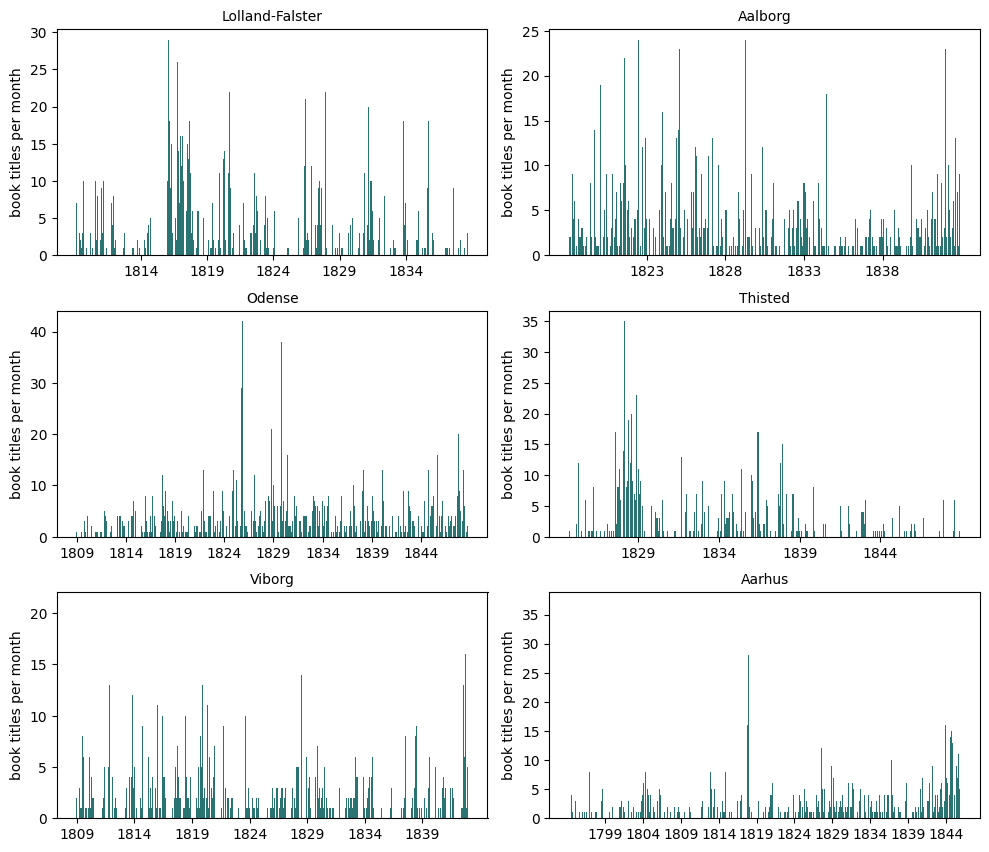

In [46]:
fig, axes = plt.subplots(3, 2, figsize=(10, 9))
axes = axes.flatten()

for ax, nsp in zip(axes, unique_newspapers):
    subset = titles_metadata[titles_metadata['newspaper'] == nsp].copy()

    # Convert date and extract month period
    subset['date'] = pd.to_datetime(subset['date'])
    subset['month'] = subset['date'].dt.to_period('M')

    # Define this newspaper's month range
    month_range = pd.period_range(subset['month'].min(), subset['month'].max(), freq='M')

    # Group and reindex to full range
    grouped = subset.groupby('month').size()
    grouped = grouped.reindex(month_range, fill_value=0)

    # Use integer positions for bar plot
    x_vals = list(range(len(grouped)))
    ax.bar(x_vals, grouped.values, color='#297373')

    # Tick labels every N years in January
    tick_positions = []
    tick_labels = []
    for i, period in enumerate(month_range):
        if period.month == 1 and (i == 0 or (period.year - month_range[0].year) % 5 == 0):
            tick_positions.append(i)
            tick_labels.append(str(period.year))

    ax.set_xticks(tick_positions)
    ax.set_xticklabels(tick_labels, rotation=0)
    ax.set_ylabel('book titles per month')
    ax.set_title(f'{newspaper_dict[nsp]}', fontsize=10)

plt.tight_layout()
plt.subplots_adjust(top=0.92)
plt.savefig('../figures/titles_per_month.pdf', bbox_inches='tight')
plt.show()

In [35]:
titles_metadata.to_csv('../results/titles_metadata_extra_250624.csv')

In [47]:
titles_metadata['newspaper'].value_counts()

newspaper
ode    1580
aar    1328
lol    1057
aal     984
vib     870
thi     644
Name: count, dtype: int64

In [48]:
titles_metadata.groupby('newspaper')['article_id'].nunique()

newspaper
aal    571
aar    858
lol    632
ode    894
thi    222
vib    567
Name: article_id, dtype: int64

In [40]:
## Count all the announcements (and articles) in the newspapers, so the number of books in there can be put in perspective. 

In [17]:
titles_metadata.shape

(6048, 7)

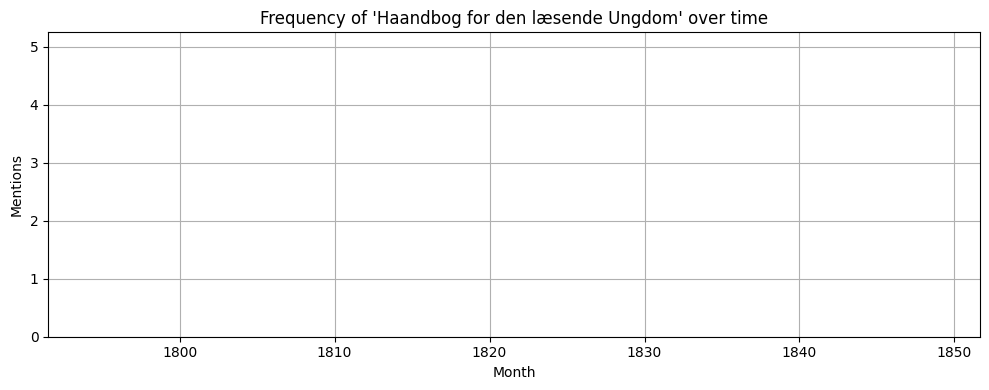

In [31]:
# Define the title you want to track
target_title = "Haandbog for den læsende Ungdom"  # lowercase to match if needed

# Make sure titles and dates are clean
titles_metadata['date'] = pd.to_datetime(titles_metadata['date'])

# Filter for the specific title
title_subset = titles_metadata[titles_metadata['cluster_label'] == target_title].copy()

# Create monthly bins
title_subset['month'] = title_subset['date'].dt.to_period('M')
monthly_counts = title_subset.groupby('month').size()

# Fill missing months in the range with 0
full_month_range = pd.period_range(titles_metadata['date'].min(), titles_metadata['date'].max(), freq='M')
monthly_counts = monthly_counts.reindex(full_month_range, fill_value=0)

# Plot
plt.figure(figsize=(10, 4))
plt.bar(monthly_counts.index.to_timestamp(), monthly_counts.values)
plt.title(f"Frequency of '{target_title}' over time")
plt.xlabel("Month")
plt.ylabel("Mentions")
plt.grid(True)
plt.tight_layout()
plt.show()